In [66]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset,random_split
from tqdm.notebook import tqdm 

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

nltk.download('wordnet')
nltk.download('stopwords')
%matplotlib inline

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [68]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report

In [69]:
url = 'https://raw.githubusercontent.com/soumyajit4419/Deep_Learning_Projects/master/NLP_With_PyTorch/Dataset/headlines.csv'
df = pd.read_csv(url)
df.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [70]:
df.shape

(26709, 3)

In [71]:
df.isnull().sum()

article_link    0
headline        0
is_sarcastic    0
dtype: int64

In [72]:
# Cleaning the text
wordnet = WordNetLemmatizer()
def clean_text(text):
  text = re.sub('[^a-zA-Z]', ' ',text)
  text = text.lower()
  text = text.split(' ')
  text = [wordnet.lemmatize(word) for word in text if word not in stopwords.words('english')]
  text = ' '.join(text)
  text = text.strip()
  return text

In [73]:
df['cleaned_text'] = df['headline'].apply(clean_text)

In [74]:
# Getting the unique words
vectorizer = CountVectorizer()
vectorizer.fit(df['cleaned_text'])

# Converting word to index and vice versa
word2idx = vectorizer.vocabulary_
word2idx['UNK'] = max(word2idx.values())+1
idx2word = {idx:word for word,idx in word2idx.items()}

vocab_size = len(word2idx)

In [75]:
text = df['cleaned_text'].iloc[0]

In [76]:
# Converting words to integer/sequence
def get_sequence(text):
  sequence = [word2idx[word] if word in word2idx.keys() else word2idx['UNK'] for word in text.split()]
  return sequence

In [77]:
# Padding the sequence
def pad_sequence(sequence,max_len=30):
  arr = np.zeros(max_len,dtype=int)
  x = min(max_len,len(sequence))
  arr[:x] = sequence[:x]
  return arr

In [78]:
df['sequence'] = df['cleaned_text'].apply(get_sequence)

In [79]:
df['padded_sequence'] = df['sequence'].apply(pad_sequence)

In [80]:
df.head()

,article_link,headline,is_sarcastic,cleaned_text,sequence,padded_sequence
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0,former versace store clerk sue secret black c...,"[7410, 20672, 18487, 3446, 18712, 17016, 1880,...","[7410, 20672, 18487, 3446, 18712, 17016, 1880,..."
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0,roseanne revival catch thorny political mood ...,"[16477, 16195, 2906, 19401, 14513, 12460, 1740...","[16477, 16195, 2906, 19401, 14513, 12460, 1740..."
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1,mom starting fear son web series closest thing...,"[12402, 18339, 6929, 17964, 21088, 17151, 3493...","[12402, 18339, 6929, 17964, 21088, 17151, 3493..."
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1,boehner want wife listen come alternative deb...,"[2040, 20962, 21261, 11132, 3653, 522, 4736, 1...","[2040, 20962, 21261, 11132, 3653, 522, 4736, 1..."
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0,j k rowling wish snape happy birthday magical...,"[21712, 21712, 16528, 21355, 17822, 8547, 1847...","[21712, 21712, 16528, 21355, 17822, 8547, 1847..."


In [81]:
# Creating the Tensors and Tensor Dataset
inputs = torch.LongTensor(df['padded_sequence'])
target = torch.FloatTensor(df[['is_sarcastic']].values)

dataset = TensorDataset(inputs,target)

In [82]:
# Dataset and Dataloader
val_split = 0.2
val_size = int(len(dataset) * 0.2)
train_size = int(len(dataset) - val_size)

train_ds,val_ds = random_split(dataset,[train_size,val_size])

batch_size = 64
train_loader = DataLoader(train_ds,batch_size=batch_size,shuffle=True,num_workers=3,pin_memory=True)
val_loader = DataLoader(val_ds,batch_size=batch_size,shuffle=True,num_workers=3,pin_memory=True)

In [83]:
# Using GPU device if available
def get_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

device = get_device()
device

device(type='cuda')

In [84]:
# Defining the model
class classifier_norm_embed(nn.Module):

  def __init__(self):
    super().__init__()
    self.embedding = nn.Embedding(vocab_size,100)
    self.lstm = nn.LSTM(100,128,num_layers=2,batch_first=True)
    self.linear = nn.Linear(128,1)

  def forward(self,xb):
    out = self.embedding(xb)
    out, (ht,ct) = self.lstm(out)
    out = ht[-1]
    out = self.linear(out)
    out = F.sigmoid(out)
    return out

In [85]:
# Instatiating the model
model = classifier_norm_embed()

In [86]:
model

classifier_norm_embed(
  (embedding): Embedding(21713, 100)
  (lstm): LSTM(100, 128, num_layers=2, batch_first=True)
  (linear): Linear(in_features=128, out_features=1, bias=True)
)

In [87]:
model = model.to(device)

In [88]:
# Function for getting the accuracy
def accuracy(pred,target):
  rounded_preds = torch.round(pred)
  correct = (rounded_preds == target).float() 
  acc = correct.sum() / len(correct)
  return acc

# Function for model evaluation
def evaluate(model):
  model.eval()
  val_loss = []
  val_acc = []
  for input,target in val_loader:
    input = input.to(device)
    target = target.to(device)
    out = model(input)
    loss = F.binary_cross_entropy(out,target)
    acc = accuracy(out,target)
    val_loss.append(loss)
    val_acc.append(acc)
  return torch.stack(val_loss).mean().item(),torch.stack(val_acc).mean().item()

In [89]:
# Function to train the model
def fit(num_epochs):
  optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
  train_losses = []
  val_losses = []
  val_accs =[]
  for epoch in range(num_epochs):
    model.train()
    batch_train_loss = []
    for input,target in tqdm(train_loader):
      input = input.to(device)
      target = target.to(device)
    
      out = model(input)
      loss = F.binary_cross_entropy(out,target)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      batch_train_loss.append(loss)

    train_loss = torch.stack(batch_train_loss).mean().item()
    val_loss,val_acc = evaluate(model)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    print("Epoch: {}, train_loss: {}, val_loss: {}, val_acc: {}".format(epoch+1,train_loss,val_loss,val_acc))

  return train_losses,val_losses,val_accs

In [90]:
# Evaluting the model
evaluate(model)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


(0.6967833638191223, 0.4397962689399719)

In [91]:
# Training the model
history = fit(10)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



Epoch: 1, train_loss: 0.6866118311882019, val_loss: 0.6854982376098633, val_acc: 0.5619996786117554



Epoch: 2, train_loss: 0.6858546137809753, val_loss: 0.6850854754447937, val_acc: 0.5635711550712585



Epoch: 3, train_loss: 0.6859062910079956, val_loss: 0.6854690909385681, val_acc: 0.5635711550712585



Epoch: 4, train_loss: 0.683299720287323, val_loss: 0.6779419779777527, val_acc: 0.6168732047080994



Epoch: 5, train_loss: 0.58172607421875, val_loss: 0.5520532131195068, val_acc: 0.7428481578826904



Epoch: 6, train_loss: 0.41490694880485535, val_loss: 0.5025117993354797, val_acc: 0.7652081251144409



Epoch: 7, train_loss: 0.2857295274734497, val_loss: 0.5498780608177185, val_acc: 0.7714940309524536



Epoch: 8, train_loss: 0.190874844789505, val_loss: 0.6381778717041016, val_acc: 0.7732771039009094



Epoch: 9, train_loss: 0.1256946474313736, val_loss: 0.7245912551879883, val_acc: 0.7678892016410828



Epoch: 10, train_loss: 0.0966101810336113, val_loss: 0.7153540253639221, val_acc: 0.7703394293785095


In [92]:
# Evaluation of the trained model
evaluate(model)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


(0.715627133846283, 0.7705639600753784)

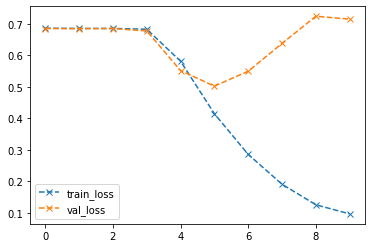

In [93]:
# Plotting the losses
train_losses,val_losses,val_acc = history 
plt.plot(train_losses,label='train_loss',linestyle='--', marker='x')
plt.plot(val_losses,label='val_loss',linestyle='--',marker='x')
plt.legend()
plt.show()